# PyMC Toy Model Example

## Bayesian Model 요약

실제 측정된 데이터의 값 z를 다음과 같이 모델링합니다.

$$
z = \eta(x, t) + e
$$

* $\eta(x, t)$ 는 실제 물리 프로세스 혹은 컴퓨터 시뮬레이션 코드의 함수이며 $x$는 함수의 인자, $t$는 함수의 파라미터로 해석할 수 있습니다.  
* 이 가정에서는 컴퓨터 모델이 실제 물리 프로세스를 완벽하게 재현함을 가정합니다. 
* $e$는 관측 에러로 시뮬레이터 에러와 관측 에러를 모두 포함합니다.

$\eta(x, t)$는 Gaussian Process의 형태로 가정됩니다.

컴퓨터 시뮬레이션 코드의 데이터는 미리 지정된 $(y_i, x_i, t_i)$로 주어지며 관측된 물리 프로세스의 데이터는 $(z_i, x_i, \theta)$ 로 주어집니다.   
여기서 $y_i$는 시뮬레이션 코드의 아웃풋을 나타내며 관측된 $\theta$는 물리 프로세스에 가장 적합한 모델 파라미터값 입니다.  
$\theta$값은 알 수 없기 때문에 이 역시 MCMC 샘플링의 대상입니다.

2개의 observed data가 설정되며 각각 다음과 같습니다
$$

\begin{align}
y_i &\sim N(f_{c,i}, \sigma_c^2) \\
f_{c,i} &\sim \text{GP for } \eta
\end{align}
$$

$$
\begin{align}
z_i &\sim N(f_{p,i}, \sigma^2) \\
f_{p,i} &\sim \text{GP for } \eta 
\end{align}
$$

모든 관측 에러는 노말 분포로 가정되었으며 따라서 전체 관측에러인 컴퓨터 에러, 실험 관측에러의 합은 여전히 노말 분포로 표현할 수 있습니다.

이 예제에서는 문제를 간단하게 하기 위하여 $ \sigma_c = \sigma $를 가정하겠습니다.  

## 1. 라이브러리 임포트

In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import pytensor.tensor as pt

## 2. 데이터 임포트

In [2]:
# c stands for computed, p stands for field (physical process).
df_c = pd.read_csv("../dataset/datacomp_hourly.csv")
df_f = pd.read_csv("../dataset/datafield_hourly.csv")

In [3]:
df_c

,yc,xc1,xc2,tc1,tc2,tc3
0,128.62,25.80,76.83,8.56,5.37,3.10
1,96.13,25.62,77.17,8.56,5.37,3.10
2,85.19,25.32,79.17,8.56,5.37,3.10
3,85.19,25.03,81.17,8.56,5.37,3.10
4,81.71,24.73,83.17,8.56,5.37,3.10
...,...,...,...,...,...,...
235,548.76,27.22,74.58,9.26,7.65,2.89
236,504.63,26.62,75.58,9.26,7.65,2.89
237,439.27,26.32,76.58,9.26,7.65,2.89
238,348.70,26.03,78.75,9.26,7.65,2.89


In [4]:
df_f

,yf,xf1,xf2
0,143.62,25.80,76.83
1,109.34,25.63,77.17
2,95.08,25.33,79.17
3,95.08,25.03,81.17
4,90.93,24.73,83.17
5,97.50,24.43,85.17
6,123.77,24.13,87.17
7,159.02,23.83,89.17
8,134.83,23.99,89.42
9,103.03,24.67,86.67


## 3. 데이터 시각화 

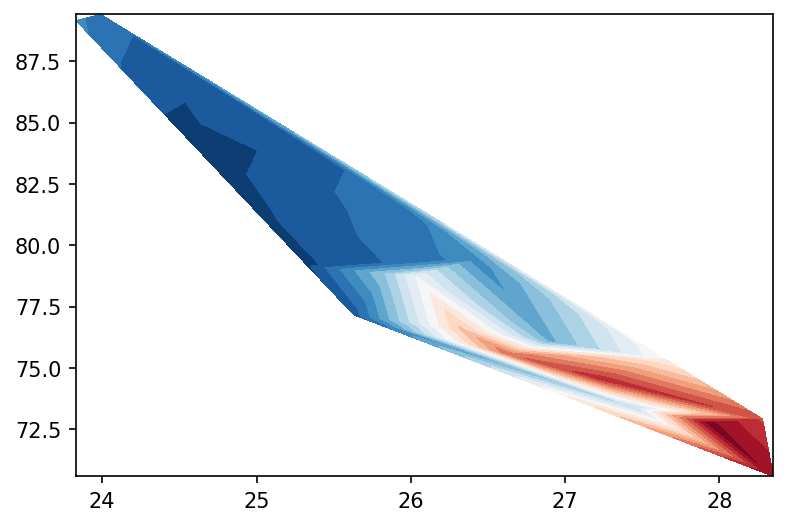

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
ax.tricontourf(
    df_f.iloc[:, 1],
    df_f.iloc[:, 2],
    df_f.iloc[:, 0],
    levels=20,
    cmap="RdBu_r"
)
plt.show()

# 4. Bayesian Inference 모델 정의

### 4-1. 모델 정의를 위한 데이터 변수명 설정

In [6]:
df_c.describe()

,yc,xc1,xc2,tc1,tc2,tc3
count,240.000000,240.00000,240.000000,240.000000,240.000000,240.000000
mean,238.212208,25.98625,79.417500,8.001000,6.422000,2.916000
std,153.872389,1.33510,5.316637,0.919768,0.734154,0.337964
min,81.710000,23.82000,70.580000,6.630000,5.370000,2.430000
25%,111.735000,24.95500,75.517500,7.100000,5.720000,2.610000
50%,161.390000,25.88000,78.790000,8.015000,6.360000,2.905000
75%,355.855000,26.98750,83.482500,8.670000,7.170000,3.240000
max,590.090000,28.35000,89.420000,9.340000,7.650000,3.450000


In [7]:
df_f.describe()

,yf,xf1,xf2
count,24.000000,24.000000,24.00000
mean,237.079167,25.990000,79.41750
std,154.280131,1.359767,5.41966
min,90.930000,23.830000,70.58000
25%,108.802500,24.955000,75.51750
50%,160.140000,25.885000,78.79000
75%,339.160000,26.987500,83.48250
max,533.400000,28.350000,89.42000


데이터 분포의 적절함을 판단하기 어렵기 때문에 더 단순한 Min-Max 정규화가 사용됩니다.

In [8]:
# Normalize the data.

# Data from computed process
y = df_c.iloc[:, 0].values
y_min = y.min()
y_max = y.max()
y = (y - y_min) / (y_max - y_min)

x_c = df_c.iloc[:, 1:3].values
x_c_min = x_c.min(axis=0)
x_c_max = x_c.max(axis=0)
x_c = (x_c - x_c_min) / (x_c_max - x_c_min)

t_c = df_c.iloc[:, 3:].values
# 파라미터의 하한선은 0으로 가정합니다.
t_c_min = 0
t_c_max = t_c.max(axis=0)
t_c = (t_c - t_c_min) / (t_c_max - t_c_min)

print(y.shape, x_c.shape, t_c.shape)

# 위에서 사용된 정규화 파라미터를 실험 데이터 정규화에도 그대로 적용합니다.
# Data from physical process
z = df_f.iloc[:, 0].values
z = (z - y_min) / (y_max - y_min)
x_p = df_f.iloc[:, 1:3].values
x_p = (x_p - x_c_min) / (x_c_max - x_c_min)

print(z.shape, x_p.shape)

(240,) (240, 2) (240, 3)
(24,) (24, 2)


### 4-2. PyMC 모델 정의

관측 에러를 Gaussian Noise로 가정했기 때문에 `gp.Latent`가 아닌 수치적으로 효율적인 `gp.Marginal`을 사용합니다.

Latent가 `gp.Larent.prior()` 함수를 사용하여 $ P(\bold{f} | X, \eta, l) $를 샘플링 한 뒤
$ P(y | \bold{f}, \sigma) = N(\bold{f}, \sigma^2) $ 에서 관측치를 예측한다면,

`gp.Marginal.marginal_likelihood()`함수는 $ \int P(y | \bold{f}, \sigma) P(\bold{f} | X, \eta, l)d\bold{f} $ 의 해석해를 이용하여
중간 샘플링 변수 $ \bold{f} $ 없이 바로 관측치를 예측합니다.

위 적분의 해석해는 $ P(y | \bold{f}, \sigma) $ 가 노말 분포로 가정될때만 구할 수 있으므로 해당조건에서만 사용되는 효율적인 함수입니다.

In [41]:
with pm.Model() as model:
    # 1. 컴퓨터 모델 에뮬레이터 GP (eta).
    # 5차원 인풋 사용 (x1, x2, t1, t2, t3).

    # 0이 아닌 값을 가지는 양수의 분포로 Gamma를 사용합니다 (분모에 들어가기 때문에 0이면 안됨).
    ls = pm.Gamma("ls", alpha=2, beta=0.5, shape=5)

    # 0 혹은 양수 값을 가지는 분포로 HalfCauchy를 사용합니다 (함수 값의 변동 폭에 해당, 0 가능).
    eta = pm.HalfCauchy("eta", beta=1)

    # 가장 기본적인 커널인 Exponential Quadratic을 사용합니다.
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=5, ls=ls)

    # 3. 컴퓨터 데이터 정의
    X_c = np.hstack([x_c, t_c])

    # # 컴퓨터 계산 노이즈 정의. 데이터를 정규화 했기 때문에 비교적 작은 값을 사용합니다.
    # sigma_c = pm.HalfNormal("sigma_c", sigma=0.01)
 
    # 4. 물리 모델 가능도 및 관측 정의.

    # theta prior 정의 (양수 값만 가능). t1, t2, t3의 3차원.
    # 파라미터의 하한선은 0으로 가정했기 양수가 나오는 약한 사전 분포를 사용합니다.
    theta = pm.Exponential("theta", lam=1, shape=3)

    # 모든 실험 과정에서 하나의 theta에서 샘플링이 되기 때문에 하나의 파라미터를 모든 관측치에 
    # 복사하여 인풋으로 사용합니다.
    X_p = pt.concatenate([x_p, pt.tile(theta, (x_p.shape[0], 1))], axis=1)
    
    # 관측 노이즈 정의. 계산보다 에러가 크다고 가정합니다.
    sigma = pm.HalfNormal("sigma", sigma=0.02)

    # 컴퓨터 데이터와 실험 데이터를 하나의 관측치로 정의합니다.
    X = pt.concatenate([X_c, X_p], axis=0)
    Y = pt.concatenate([y, z], axis=0)
    # sigma_all = pt.concatenate([pt.fill(y, sigma_c), pt.fill(z, sigma)], axis=0)

    # 평균값은 0으로 가정합니다 (커널만으로 충분히 함수 형태가 표현되기 때문에 평균값이 0이 됩니다).
    gp = pm.gp.Marginal(cov_func=cov)
    y_z_obs = gp.marginal_likelihood("y_z_obs", X=X, y=Y, sigma=sigma)

    # Prior version... 정리 필요
    # gp = pm.gp.Latent(cov_func=cov)
    # f_c = gp.prior("f_c", X=X_c)
    # y_obs = pm.Normal("y_obs", mu=f_c, sigma=sigma_c, observed=y)

    # 관측 데이터 정의.
    # f_p = gp.prior("f_p", X=X_p)
    # z_obs = pm.Normal("z_obs", mu=f_p, sigma=sigma, observed=z)

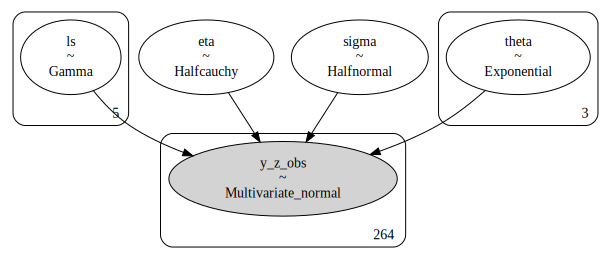

In [42]:
pm.model_to_graphviz(model)

# 5. Sampling 수행

In [43]:
with model:
    trace = pm.sample(
        draws=1000, tune=1000, chains=1, cores=1,
        nuts_sampler="numpyro",
        target_accept=0.95,
        # rogressbar=False,                     # 여기
        # nuts_sampler_kwargs={"progress_bar": False}, 
    )

sample: 100%|██████████| 2000/2000 [02:33<00:00, 13.00it/s, 7 steps of size 1.62e-01. acc. prob=0.94] 
Only one chain was sampled, this makes it impossible to run some convergence checks


$l$, `ls`가 큰 값을 가진다는 것은 해당 차원의 인자 값이 서로 크게 달라도 커널 값의 변화가 작다는 뜻입니다.  
이는 해당 변수가 중요하지 않다는 의미로 해석할 여지가 있습니다. 변수의 스케일에도 영향을 받기 때문에 해석에 주의가 필요합니다.

아래 시각화에서 2, 3, 4 차원, 즉 t1, t2, t3의 중요도는 낮은 것으로 보입니다. 

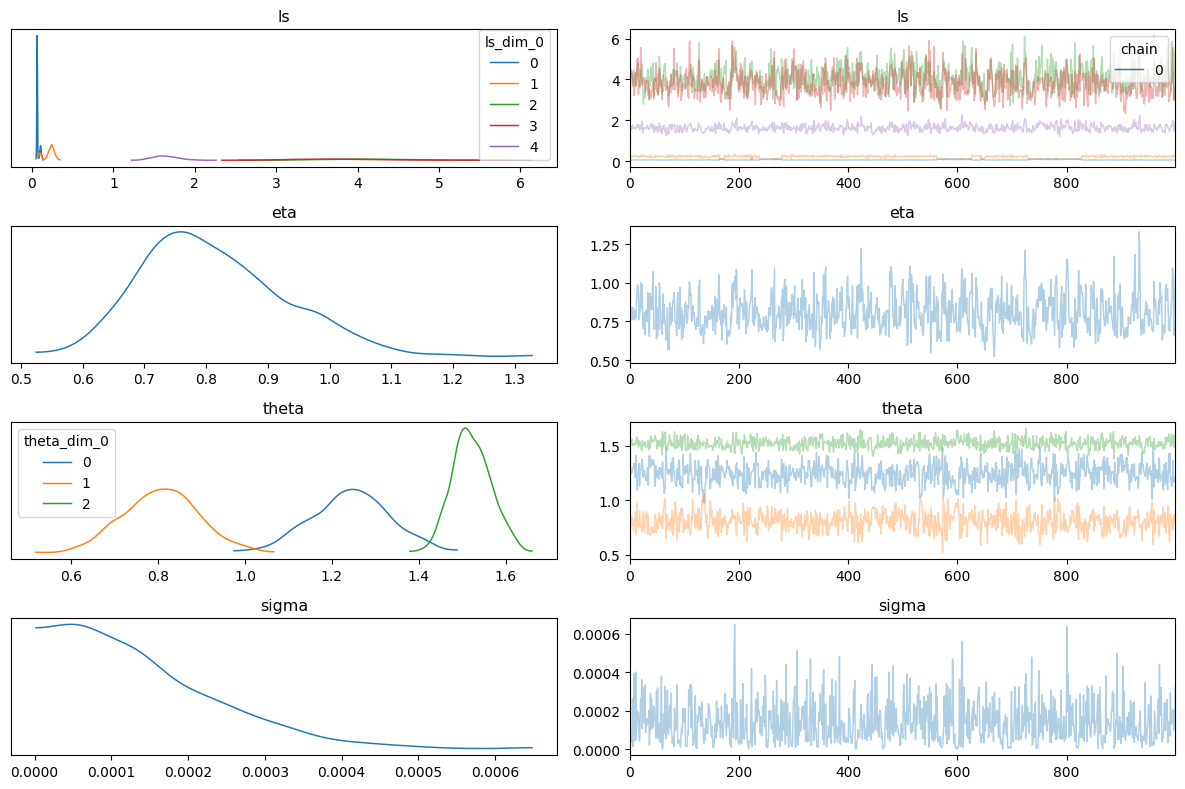

In [44]:
az.plot_trace(trace, legend=True)
plt.tight_layout()
plt.show()

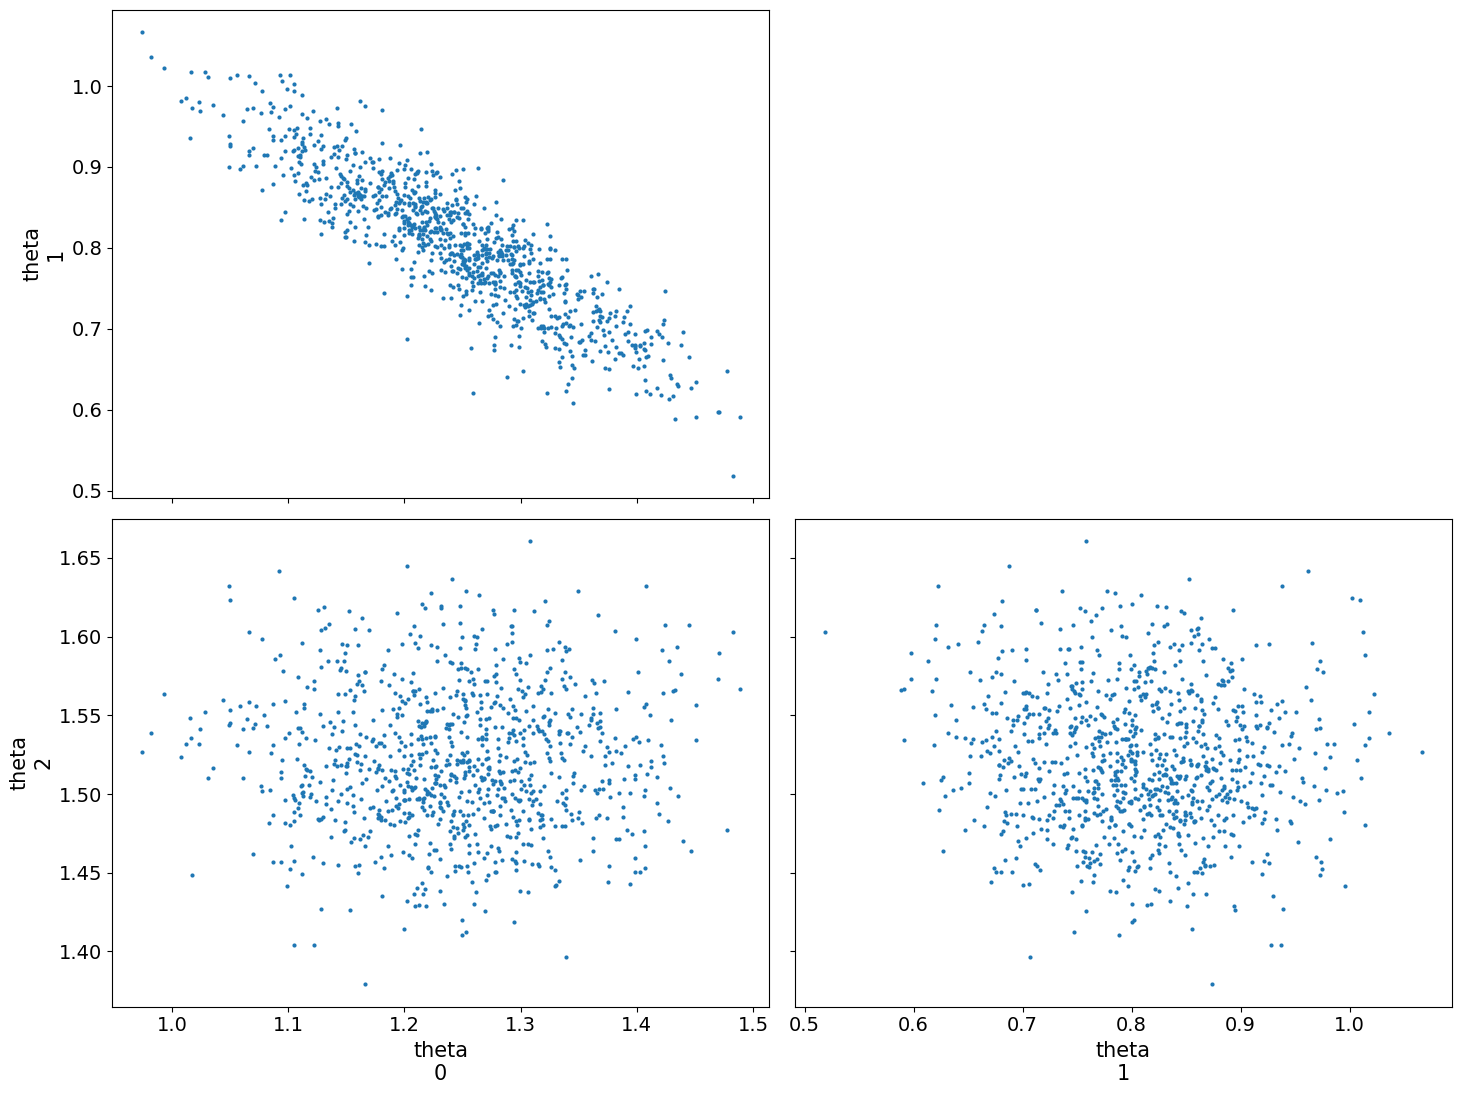

In [45]:
az.plot_pair(trace, var_names=["theta"])
plt.tight_layout()
plt.show()

In [46]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [47]:
with model:
    # Posterior Predictive Sampling.
    y_pred = gp.conditional("y_pred", Xnew=X_c, pred_noise=True)
    z_pred = gp.conditional("z_pred", Xnew=X_p, pred_noise=True)

    samples = pm.sample_posterior_predictive(
        trace,
        var_names=["y_pred", "z_pred"],
    )

Sampling: [y_pred, z_pred]


Output()

1차원 데이터가 아닌 2차원 데이터 + 파라미터 차원을 1차원으로 나열하여 시각화 하는 것은 옳지 않지만 대략적인 직관을 얻기 위하여  
단순하게 시각화 합니다.

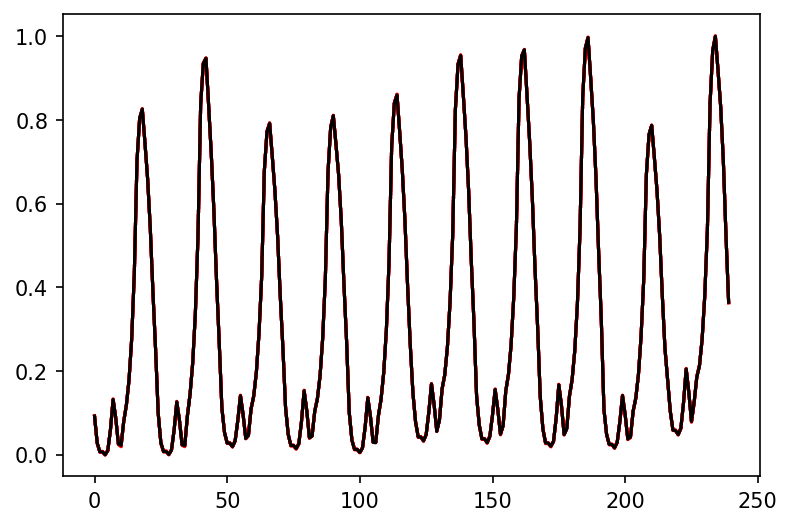

In [50]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
for i in range(100):
    y_val = samples.posterior_predictive.y_pred.stack(sample=("draw", "chain")).isel(sample=i)
    ax.plot(y_val, alpha=0.05, color='red')
ax.plot(y, color='black', label='True')
plt.show()

관측치 z에 대해서도 유사한 시각화를 수행합니다.

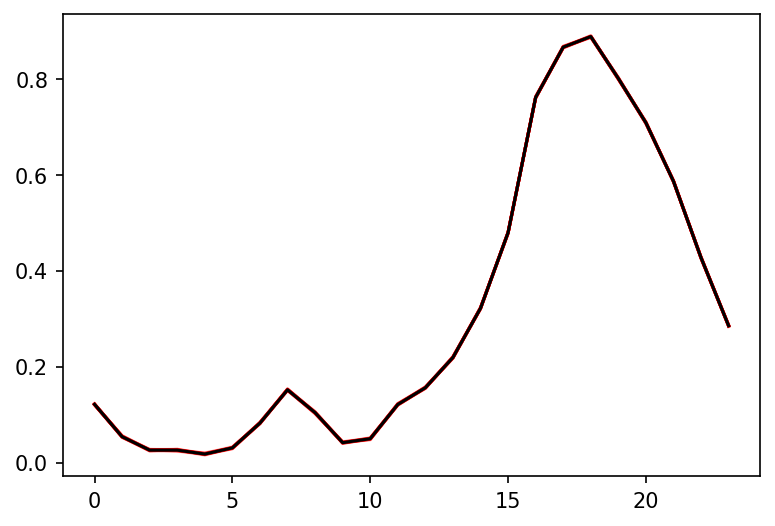

In [51]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
for i in range(100):
    z_val = samples.posterior_predictive.z_pred.stack(sample=("draw", "chain")).isel(sample=i)
    ax.plot(z_val, alpha=0.05, color='red')
ax.plot(z, color='black', label='True')
plt.show()